In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
df = pd.read_csv('estadisticas_fantasy.csv')
print(df)

     Unnamed: 0          Nombre Posición        Equipo  Puntos  \
0             0     Lewandowski       DL  FC Barcelona     146   
1             1        Raphinha       DL  FC Barcelona     143   
2             2    Lamine Yamal       DL  FC Barcelona     137   
3             3    Vinícius Jr.       DL   Real Madrid     118   
4             4          Mbappe       DL   Real Madrid     102   
..          ...             ...      ...           ...     ...   
585         585         Vallejo       DF   Real Madrid      -1   
586         586          Adrián       PO    Real Betis      -2   
587         587  Rodrigo Abajas       DF   Valencia CF      -2   
588         588     Juan Carlos       PO        Girona      -3   
589         589        R Chasco       DF    Valladolid      -3   

     Media Puntos Relevo  Puntos Relevo Precio Actual Precio Inicial  Media  \
0                   2.85             37   127.371.980    127.397.088  11.23   
1                   3.23             42   125.574

In [3]:
### EDA ###

In [4]:
print("num_atributs: ", len(df.keys()))
nan_columns = df.columns[df.isna().sum()>0].tolist()
print("NaNs: ", nan_columns)
print("num nans", df.isna().sum().sum())
print("Describe\n", df.describe())
print("\n\ninfo:\n", df.info())
print("\n\nnunique:\n", df.nunique())

num_atributs:  31
NaNs:  []
num nans 0
Describe
        Unnamed: 0      Puntos  Media Puntos Relevo  Puntos Relevo       Media  \
count  590.000000  590.000000           590.000000     590.000000  590.000000   
mean   294.500000   27.794915             0.893814       9.661017    2.543678   
std    170.462606   25.861069             0.795729       9.135669    2.227177   
min      0.000000   -3.000000             0.000000       0.000000   -0.330000   
25%    147.250000    7.250000             0.000000       0.000000    0.730000   
50%    294.500000   21.000000             0.750000       8.000000    2.180000   
75%    441.750000   46.000000             1.400000      15.000000    4.000000   
max    589.000000  146.000000             3.580000      43.000000   11.420000   

         Partidos      Minutos       Goles  Asistencias  Asistencias sin Gol  \
count  590.000000   590.000000  590.000000   590.000000           590.000000   
mean     9.001695   399.581356    0.479661     0.362712      

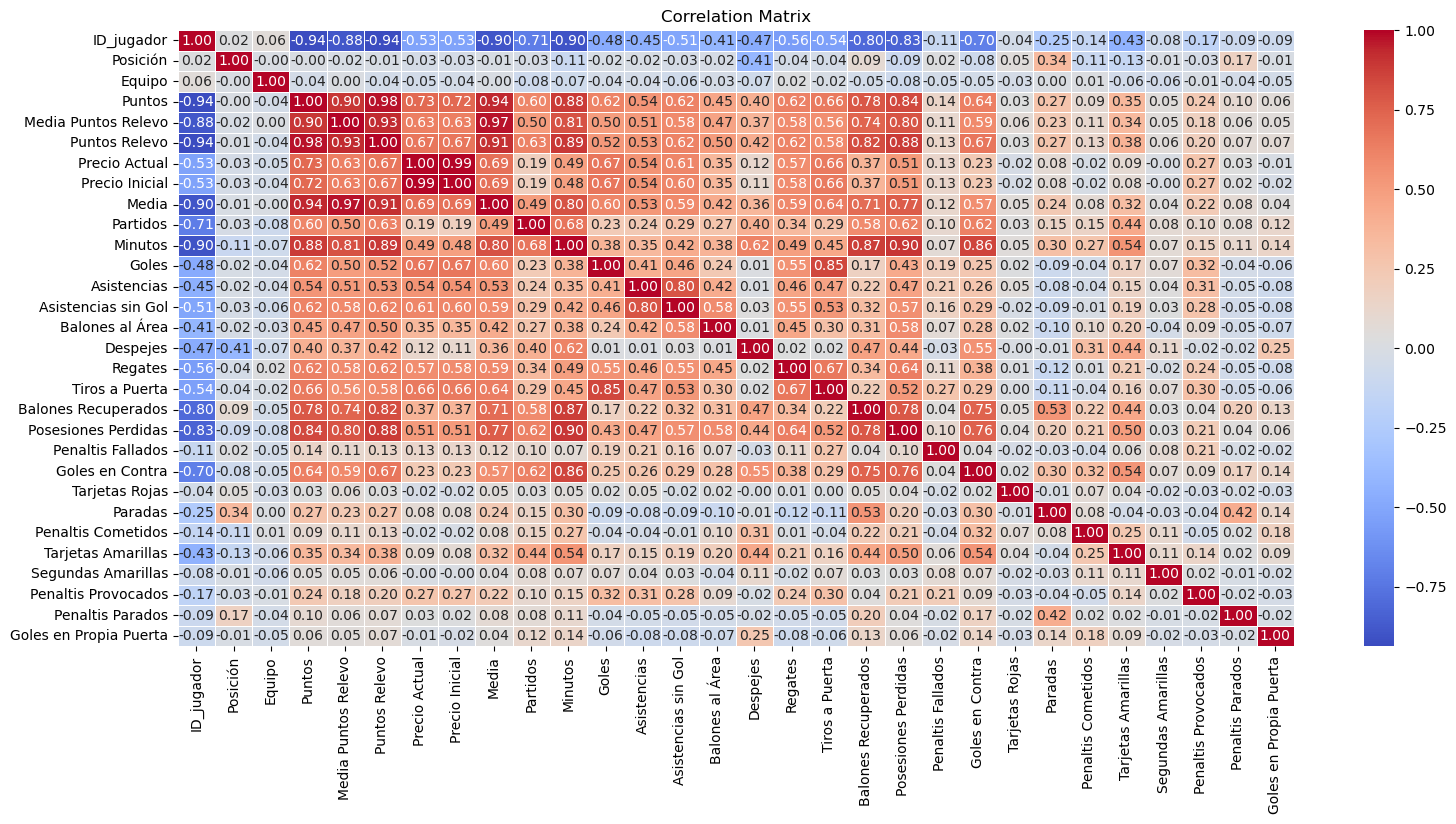

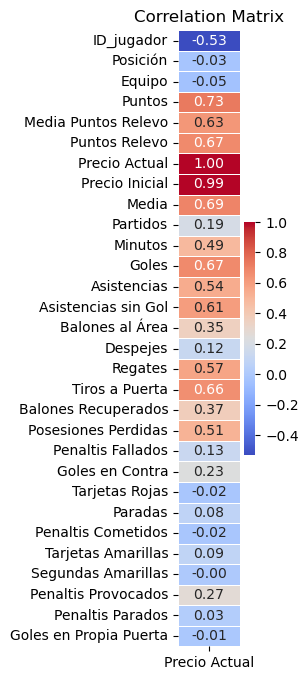

In [5]:
df.rename(columns={'Unnamed: 0': 'ID_jugador'}, inplace=True)

df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')

df['Precio Actual'] = df['Precio Actual'].astype(int)
df['Precio Inicial'] = df['Precio Inicial'].astype(int)


df = df[df['Posición'] != 'DT']
le = LabelEncoder()
# 0: Defensa 1: Davanter 2: Migcampista 3: Porter 4: DT no hi ha)
df['Posición'] = le.fit_transform(df['Posición'])
df['Equipo'] = le.fit_transform(df['Equipo'])

df.drop(columns=['Nombre'], inplace=True)

corr_matrix = df.corr()
corr_dif_preu = corr_matrix[['Precio Actual']]

plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

plt.figure(figsize=(1,8))
sns.heatmap(corr_dif_preu, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# com veiem que no hi ha gaire relacio entre la diferencia de preu i la resta de variables, fem features engineering
df['Gols_per_Minuts'] = df['Goles'] / (df['Minutos'] + 1e-9)  # Afegir 1e-9 per evitar dividir per 0
df['Assistencies_per_Partit'] = df['Asistencias'] / (df['Partidos'] + 1e-9)
df['Gols_Assistencies'] = df['Goles'] + df['Asistencias']
df['Percentatge_gols'] = df['Goles']/df.groupby('Equipo')['Goles'].sum()[df['Equipo'].values].values

df.drop(columns=['ID_jugador'], inplace=True)
df.drop(columns=['Precio Inicial'], inplace=True) #Hem provat de modelar la diferencia i el percentatge de millora, pero no funciona gaire be
# Anem a carregar-nos les columens molt relacionades entre elles i despres fem rfe per quedarnos amb les mes importatns
df.drop(columns=['Media', 'Media Puntos Relevo', 'Goles', 'Asistencias'], inplace=True)




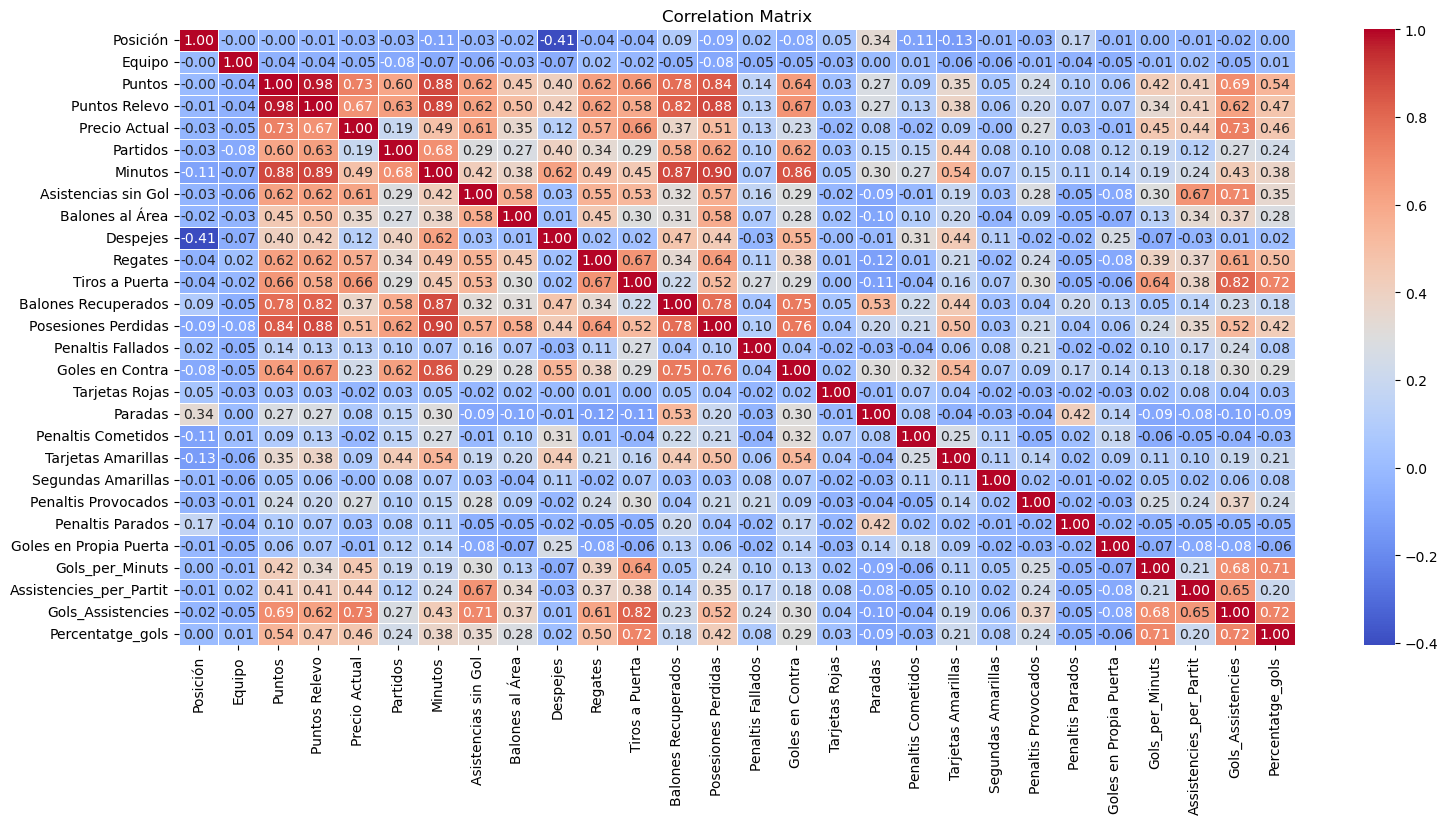

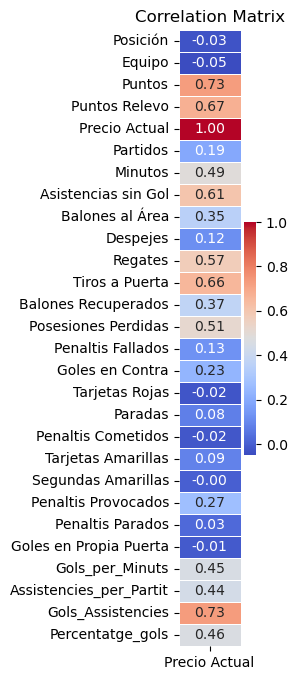

In [6]:
corr_matrix = df.corr()
corr_dif_preu = corr_matrix[['Precio Actual']]

plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

plt.figure(figsize=(1,8))
sns.heatmap(corr_dif_preu, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

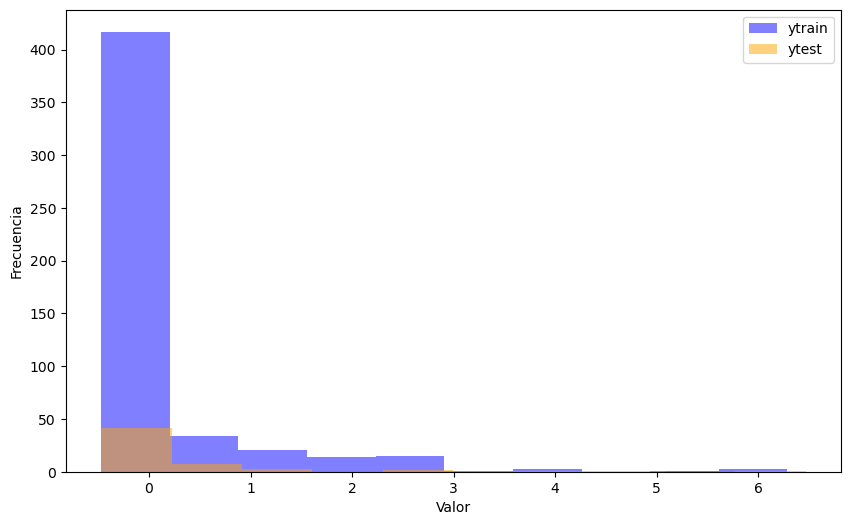

In [7]:
target_att = 'Precio Actual'

attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes].to_numpy()
y = df[[target_att]].to_numpy()


sc = StandardScaler()
X_norm = sc.fit_transform(X)
y_norm = sc.fit_transform(y)

X_train, X_test, y_train , y_test = train_test_split(X_norm,y_norm,test_size = 0.1, random_state=42)

plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=10, alpha=0.5, label='ytrain', color='blue', )
plt.hist(y_test, bins=10, alpha=0.5, label='ytest', color='orange')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


In [8]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)


0.7412481897661429 0.7651662828616725


/tmp/ipykernel_23847/674296424.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  plt.scatter(y_train,y_pred_train, norm='Normalize')


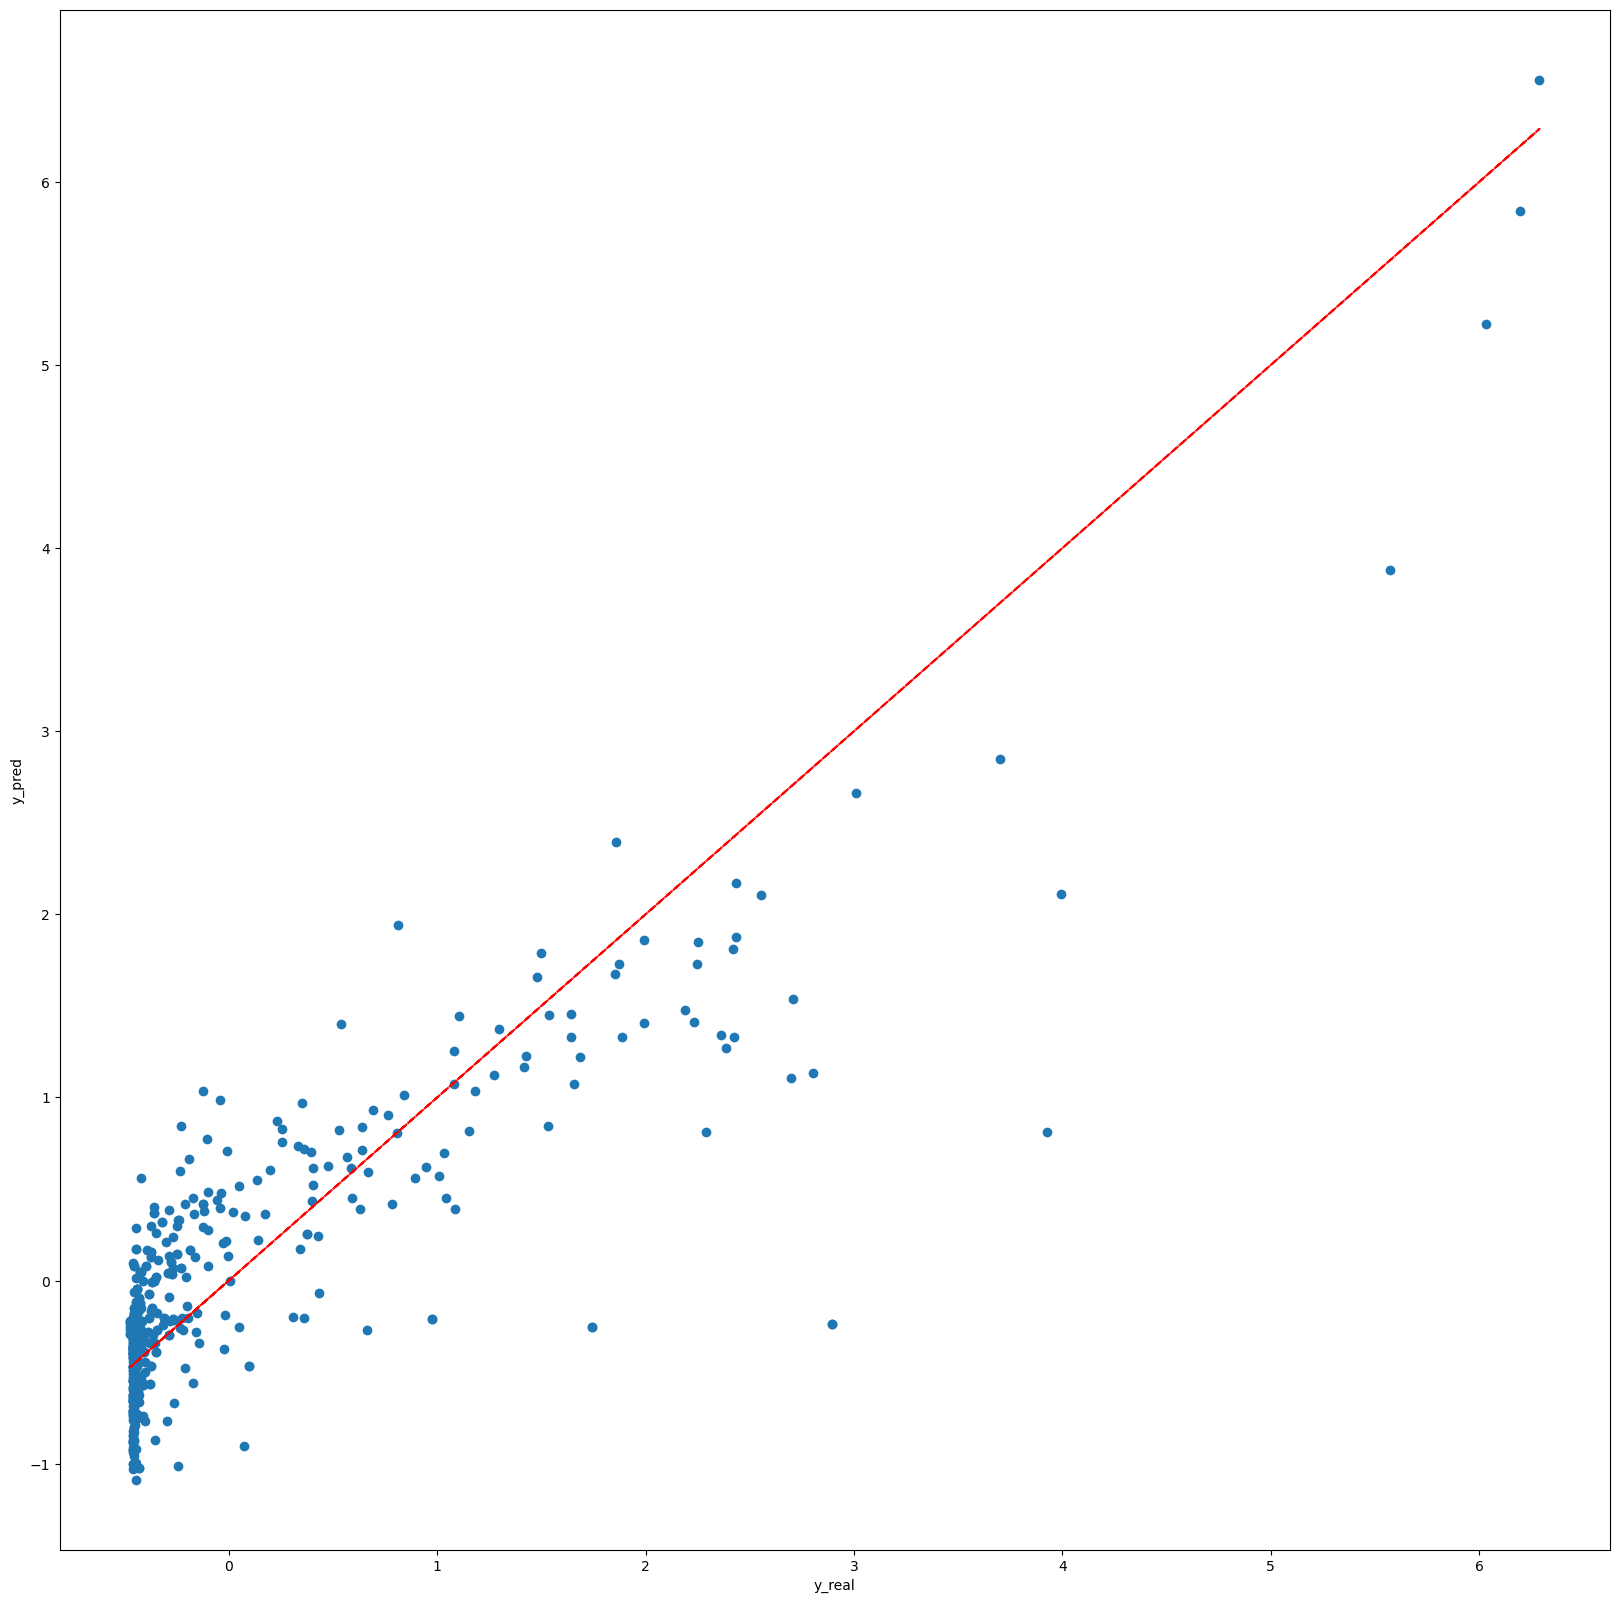

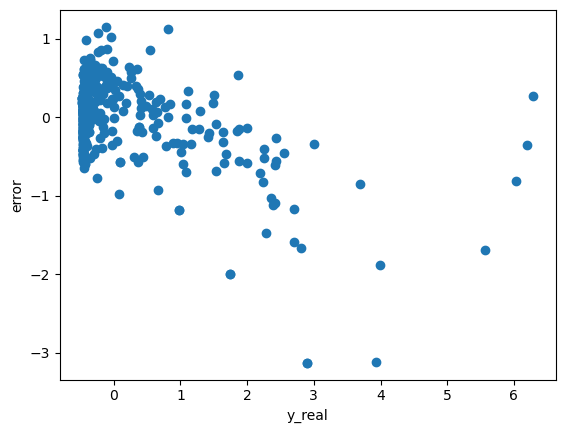

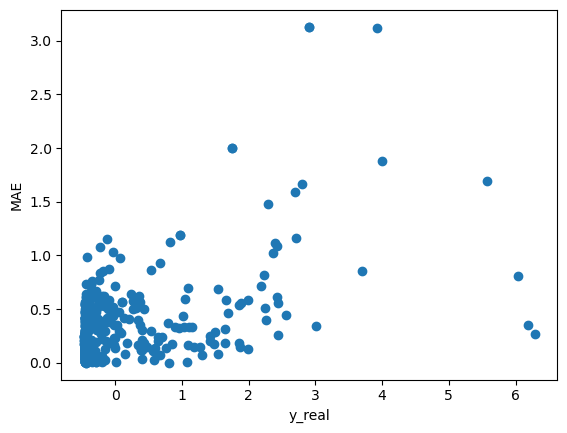

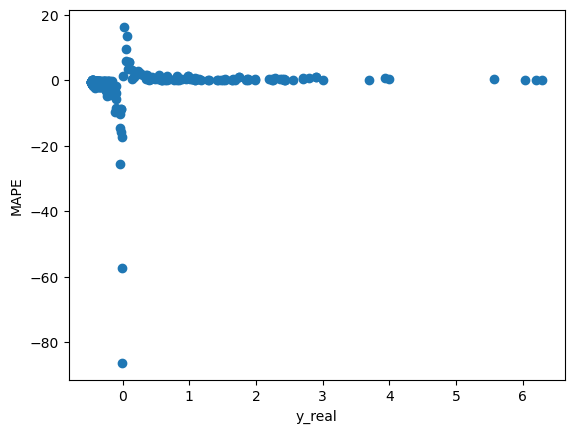

In [9]:
plt.figure(figsize=(20,20))
y_train = np.array(y_train).flatten()
y_pred_train = y_pred_train.flatten()
plt.scatter(y_train,y_pred_train, norm='Normalize')
plt.plot(y_train,y_train,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

plt.scatter(y_train,y_pred_train-y_train)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y_train,abs(y_pred_train-y_train))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()


plt.scatter(y_train,abs(y_pred_train-y_train)/y_train)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()

In [10]:
lass = LassoCV(cv=5, random_state=40)
lass.fit(X_train,y_train)

y_pred = lass.predict(X_test)
y_pred_train = lass.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)
for i in range(len(attributes)):
    print(f'{attributes[i]} {lass.coef_[i]}')


0.7330919733415596 0.7705029595995022
Posición -0.02791333730636631
Equipo -0.0033763331681354127
Puntos 0.6863620818647699
Puntos Relevo 0.04863356974525369
Partidos -0.2086595542172895
Minutos 0.0
Asistencias sin Gol 0.0
Balones al Área 0.0
Despejes 0.0
Regates 0.09134119406688625
Tiros a Puerta 0.0
Balones Recuperados -0.049699159909878464
Posesiones Perdidas -0.008967203977384519
Penaltis Fallados -0.011287416506074151
Goles en Contra -0.15261757259054576
Tarjetas Rojas -0.02424796524338625
Paradas 0.00712632815880342
Penaltis Cometidos 0.009084200057372574
Tarjetas Amarillas -0.0402930407005674
Segundas Amarillas -0.01517279348058876
Penaltis Provocados 0.0
Penaltis Parados 0.018540485352300514
Goles en Propia Puerta 0.010227322158125092
Gols_per_Minuts -0.052159876126669676
Assistencies_per_Partit -0.13846749396424674
Gols_Assistencies 0.5101905582240999
Percentatge_gols -0.15690729016950666


In [11]:
rid = RidgeCV(cv=5)
rid.fit(X_train,y_train)

y_pred = rid.predict(X_test)
y_pred_train = rid.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)

0.7387679093777062 0.7704668870897216


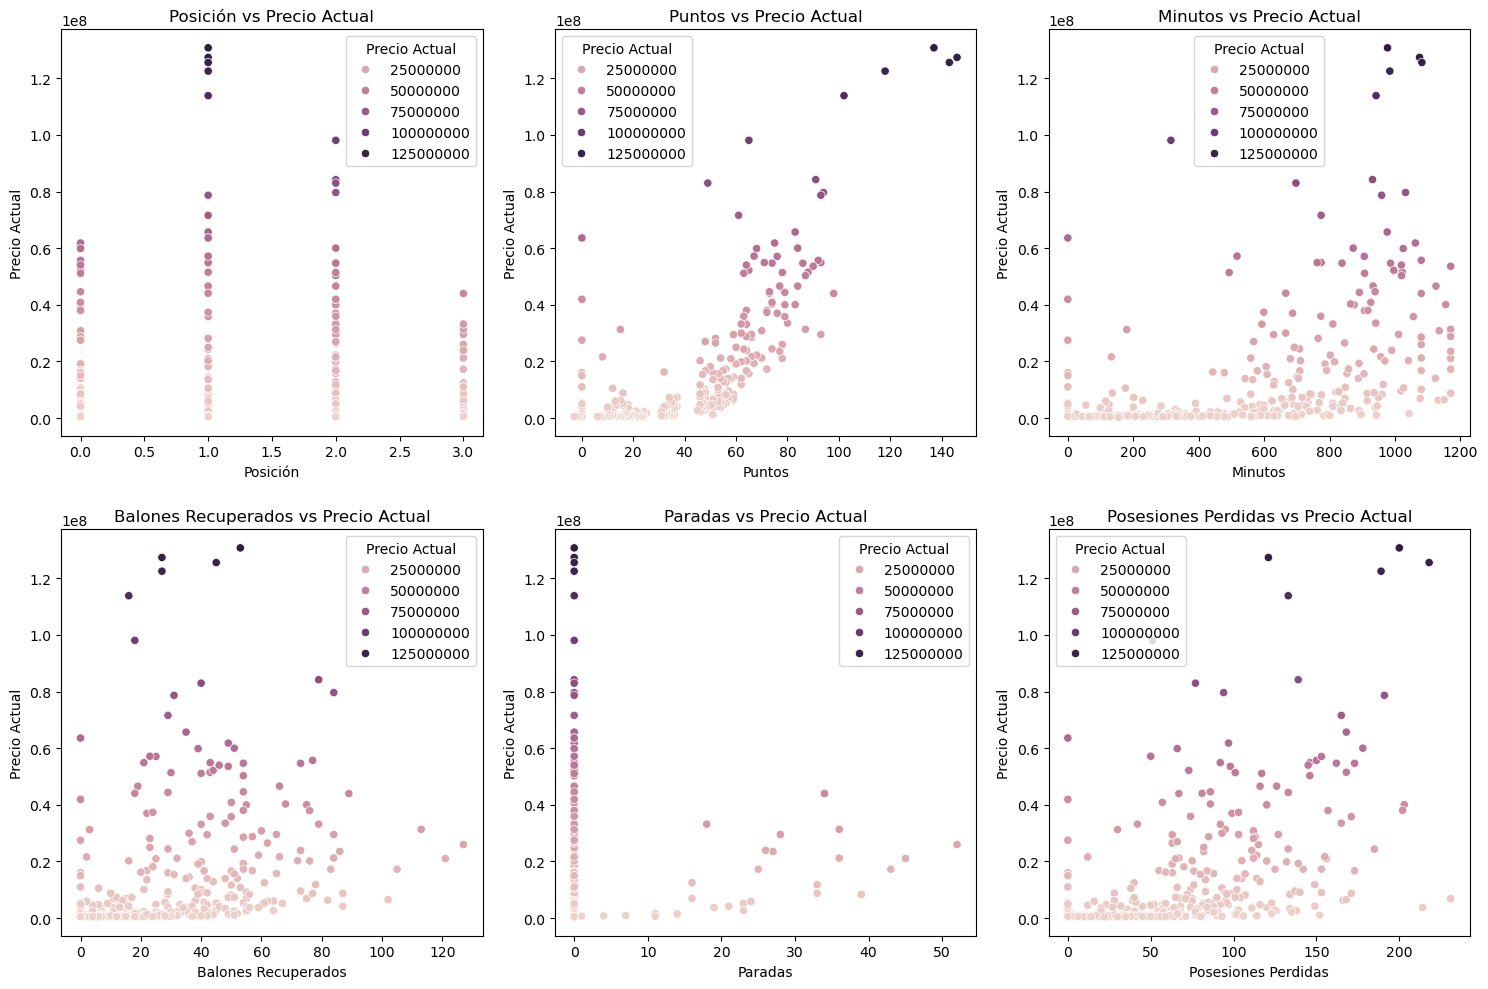

In [12]:
selected2plot = ['Posición', 'Puntos', 'Minutos', 'Balones Recuperados', 'Paradas', 'Posesiones Perdidas']
n = len(selected2plot)
rows = 2
cols = (n + rows - 1) // rows  

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for i, var in enumerate(selected2plot):
    row, col = divmod(i, cols) 
    sns.scatterplot(data=df, x=var, y=target_att, hue=target_att, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs {target_att}')

for j in range(n, rows*cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    # "LightGBM": LGBMRegressor(verbose=-1),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

results_rfe = {}
results_sfs = {}
for name, model in models.items():
    model_rfe = RFECV(model, min_features_to_select=5, cv=5, n_jobs=-1)
    model_rfe.fit(X_train, y_train)

    sfs = SFS(model, k_features=(1, model_rfe.n_features_), forward=True, floating=False, scoring='r2', cv=5, n_jobs=-1)
    sfs.fit(X_train, y_train)

    y_pred_train = model_rfe.predict(X_train)
    y_pred_test = model_rfe.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)


    selected_features = list(sfs.k_feature_idx_)
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    
    model.fit(X_train_selected, y_train)
    y_pred_train_sfs = model.predict(X_train_selected)
    y_pred_test_sfs = model.predict(X_test_selected)
    r2_train_sfs = r2_score(y_train, y_pred_train_sfs)
    r2_test_sfs = r2_score(y_test, y_pred_test_sfs)
    mae_train_sfs = mean_absolute_error(y_train, y_pred_train_sfs)
    mae_test_sfs = mean_absolute_error(y_test, y_pred_test_sfs)
    mse_train_sfs = mean_squared_error(y_train, y_pred_train_sfs)
    mse_test_sfs = mean_squared_error(y_test, y_pred_test_sfs)

    results_rfe[name] = {"model": model_rfe,"features": model_rfe.n_features_ , "caracteristicas": model_rfe.support_, "MAE Train": mae_train, "MAE Test": mae_test, "MSE Train": mse_train, "MSE Test": mse_test,'R2 Train': r2_train, 'R2 Test': r2_test}
    results_sfs[name] = {"model": sfs,"features": sfs.k_feature_names_, "MAE Train": mae_train_sfs, "MAE Test": mae_test_sfs, "MSE Train": mse_train_sfs, "MSE Test": mse_test_sfs,'R2 Train': r2_train_sfs, 'R2 Test': r2_test_sfs}


Linear Regression LinearRegression()


Random Forest RandomForestRegressor()
XGBoost XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
AdaBoost AdaBoostRegressor()


In [16]:
print("MODEL RFE")
for model_name in results_rfe:
    for results in results_rfe[model_name]:
        print(f"{model_name} {results}: {results_rfe[model_name][results]}")

print("\n\n\nMODEL SFS")
for model_name in results_sfs:
    for results in results_sfs[model_name]:
        print(f"{model_name} {results}: {results_sfs[model_name][results]}")

MODEL RFE
Linear Regression model: RFECV(cv=5, estimator=LinearRegression(), min_features_to_select=5, n_jobs=-1)
Linear Regression features: 13
Linear Regression caracteristicas: [False False  True  True  True  True False False False  True False  True
  True False  True False  True False False False False False False  True
  True  True  True]
Linear Regression MAE Train: 0.3225927623837758
Linear Regression MAE Test: 0.44605013139266875
Linear Regression MSE Train: 0.23523595188489016
Linear Regression MSE Test: 0.4732602182216809
Linear Regression R2 Train: 0.7351201258051094
Linear Regression R2 Test: 0.7548963454952051
Random Forest model: RFECV(cv=5, estimator=RandomForestRegressor(), min_features_to_select=5,
      n_jobs=-1)
Random Forest features: 8
Random Forest caracteristicas: [ True  True  True  True  True False False False False False False  True
 False False False False False False False False False False False  True
 False  True False]
Random Forest MAE Train: 0.07723396

In [27]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    # "LightGBM": LGBMRegressor(verbose=-1),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

results_rfe = {}

for name, model in models.items():
    model_rfe = RFECV(model, min_features_to_select=5, cv=5, n_jobs=-1)
    model_rfe.fit(X_train, y_train)
    
    X_train_selected = X_train[:, model_rfe.support_] 
    X_test_selected = X_test[:, model_rfe.support_]

    best_model = model_rfe.estimator_

    param_grid = {
        "Linear Regression": {
            'fit_intercept': [True, False]
        },
        "Random Forest": {
            'n_estimators': [50, 100, 200], 
            'max_depth': [None, 10, 20, 30], 
            'min_samples_split': [2, 5, 10]
        },
        # "LightGBM": {
        #     'num_leaves': [31, 50, 100], 
        #     'learning_rate': [0.05, 0.1, 0.2], 
        #     'n_estimators': [100, 200, 500]
        # },
        "XGBoost": {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 10]
        },
        "AdaBoost": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    }

    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid[name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_selected, y_train)
    best_model_grid = grid_search.best_estimator_

    y_pred_train = best_model_grid.predict(X_train_selected)
    y_pred_test = best_model_grid.predict(X_test_selected)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    results_rfe[name] = {
        "Model": best_model_grid,
        "Best Parameters": grid_search.best_params_,
        "features": model_rfe.n_features_,
        "caracteristicas": model_rfe.support_,
        "MAE Train": mae_train, 
        "MAE Test": mae_test, 
        "MSE Train": mse_train, 
        "MSE Test": mse_test,
        'R2 Train': r2_train, 
        'R2 Test': r2_test
    }

    print(f"Mejores parámetros para {name}: {grid_search.best_params_}")
    print(f"R2 Train: {r2_train}, R2 Test: {r2_test}")
    print(f"MAE Train: {mae_train}, MAE Test: {mae_test}")
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
    print("-" * 50)


    


Mejores parámetros para Linear Regression: {'fit_intercept': False}
R2 Train: 0.7351047719985934, R2 Test: 0.7551220933145418
MAE Train: 0.3232707186261774, MAE Test: 0.44685946118614206
MSE Train: 0.23524958737645726, MSE Test: 0.4728243313620656
--------------------------------------------------
Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
R2 Train: 0.938178747331994, R2 Test: 0.7741812846283449
MAE Train: 0.08005019070349745, MAE Test: 0.2932519622690447
MSE Train: 0.054902552571339185, MSE Test: 0.4360237497529376
--------------------------------------------------
Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
R2 Train: 0.9322183498666073, R2 Test: 0.7975124767217201
MAE Train: 0.10611163833848991, MAE Test: 0.32583840464901714
MSE Train: 0.060195894602870476, MSE Test: 0.3909745435965002
--------------------------------------------------
Mejores parámetros para AdaBoost: {'learnin

In [28]:
best_model_overall = results_rfe['XGBoost']
best_model_overall

{'Model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'Best Parameters': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100},
 'features': 13,
 'caracteristicas': array([ True,  True,  True,  True,  True, False, False, False, False,
         True,  True,  True, False, False,  T

In [29]:
#provem a fer bagging
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(),
                           n_estimators=50,
                           random_state=42)

bagging.fit(X_train, y_train)
y_pred_train_bagging = bagging.predict(X_train)
y_pred_test_bagging = bagging.predict(X_test)
print(r2_score(y_train, y_pred_train_bagging))
print(r2_score(y_test, y_pred_test_bagging))


0.9417480616731875
0.7829012001763108


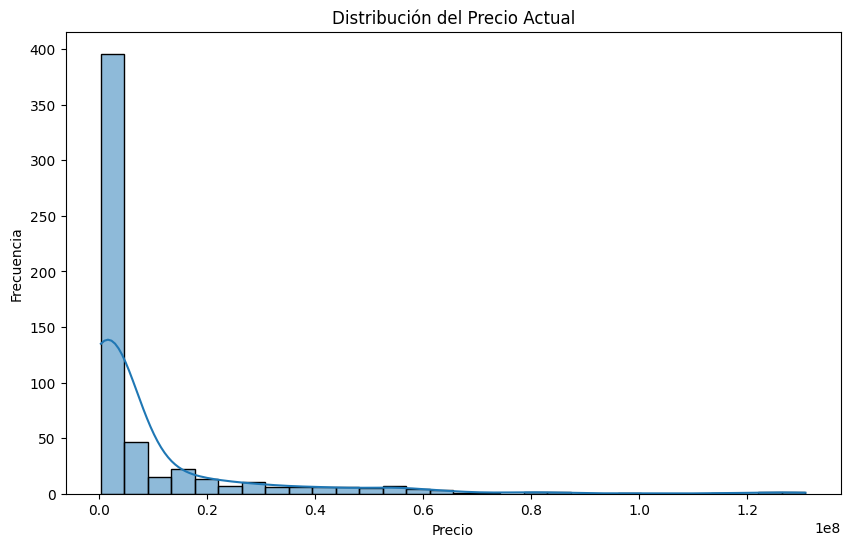

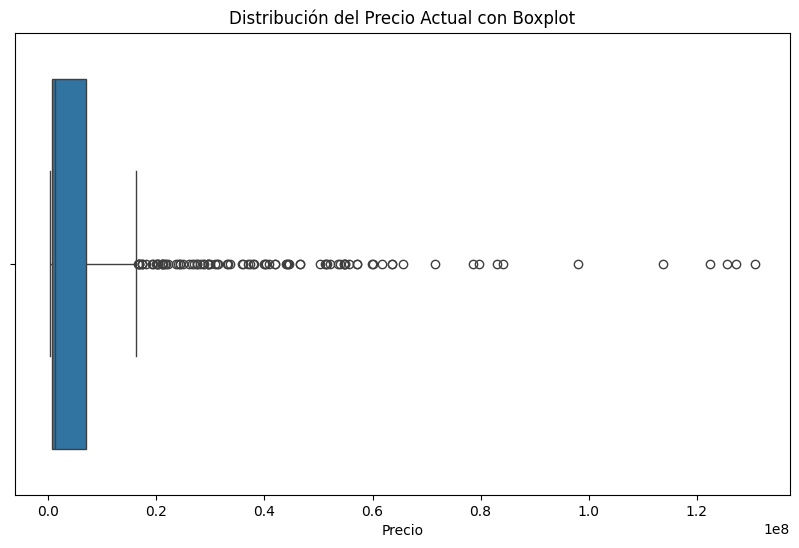

/tmp/ipykernel_8018/3619570498.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Precio Actual'], shade=True, color='orange')


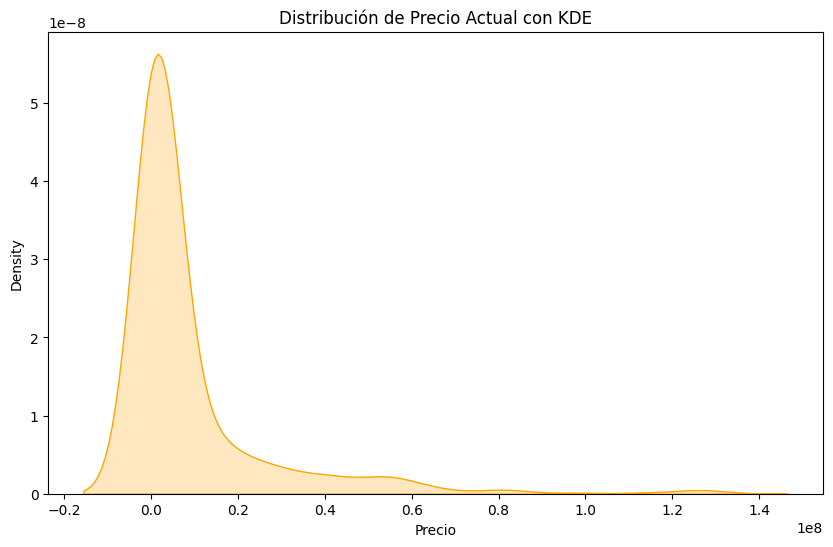

In [24]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['Precio Actual'], bins=30, kde=True)
plt.title('Distribución del Precio Actual')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

# Diagrama de caja (boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Precio Actual'])
plt.title('Distribución del Precio Actual con Boxplot')
plt.xlabel('Precio')
plt.show()

# Gráfico de densidad (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Precio Actual'], shade=True, color='orange')
plt.title('Distribución de Precio Actual con KDE')
plt.xlabel('Precio')
plt.show()


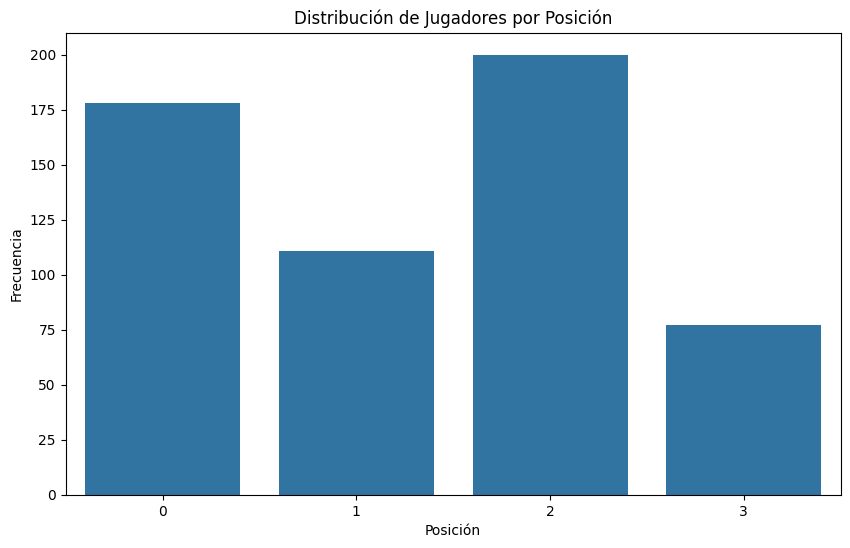

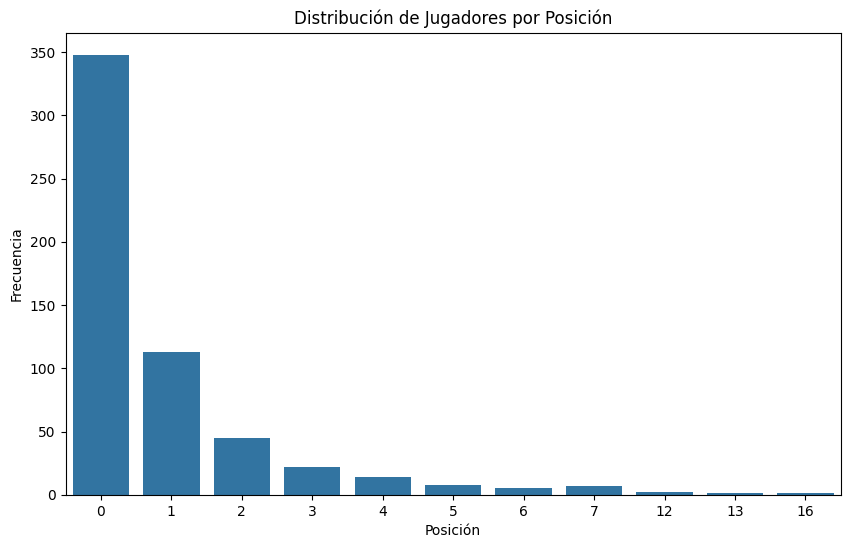

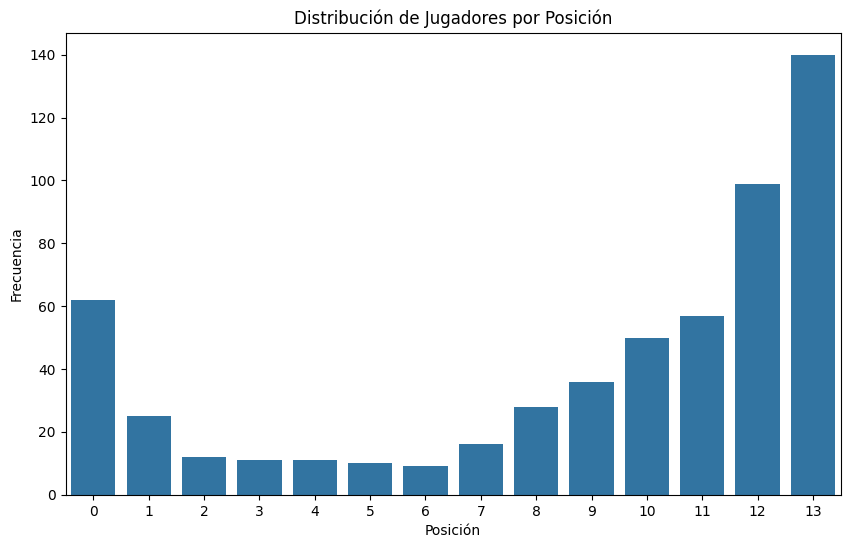

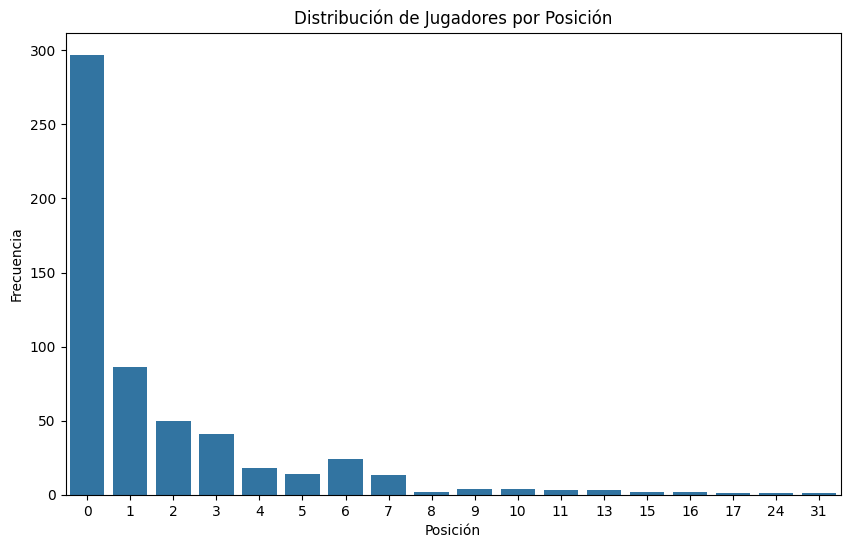

In [59]:
# Gráfico de barras (para ver la distribución de 'Posición' por ejemplo)
plt.figure(figsize=(10, 6))
sns.countplot(x='Posición', data=df)
plt.title('Distribución de Jugadores por Posición')
plt.xlabel('Posición')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras (para ver la distribución de 'Posición' por ejemplo)
plt.figure(figsize=(10, 6))
sns.countplot(x='Gols_Assistencies', data=df)
plt.title('Distribución de Jugadores por Posición')
plt.xlabel('Posición')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras (para ver la distribución de 'Posición' por ejemplo)
plt.figure(figsize=(10, 6))
sns.countplot(x='Partidos', data=df)
plt.title('Distribución de Jugadores por Posición')
plt.xlabel('Posición')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras (para ver la distribución de 'Posición' por ejemplo)
plt.figure(figsize=(10, 6))
sns.countplot(x='Tiros a Puerta', data=df)
plt.title('Distribución de Jugadores por Posición')
plt.xlabel('Posición')
plt.ylabel('Frecuencia')
plt.show()


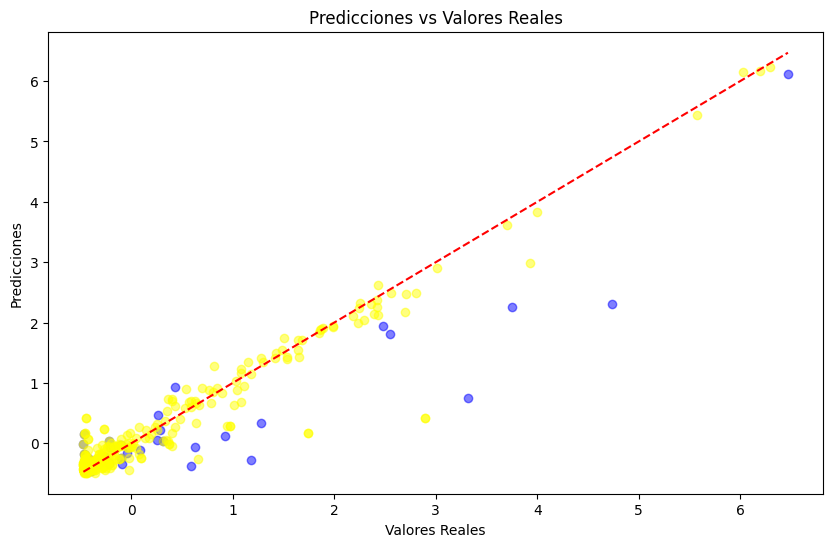

In [40]:
X_train_new = X_train[:, best_model_overall['caracteristicas']]  # Solo las características seleccionadas
X_test_new = X_test[:, best_model_overall['caracteristicas']]

y_pred_train_new = best_model_overall['Model'].predict(X_train_new)  # Usa tu modelo ajustado
y_pred_test_new = best_model_overall['Model'].predict(X_test_new)  # Usa tu modelo ajustado

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_new, color='blue', alpha=0.5)
plt.scatter(y_train, y_pred_train_new, color='yellow', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de identidad
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


(57, 1)
(57, 1)


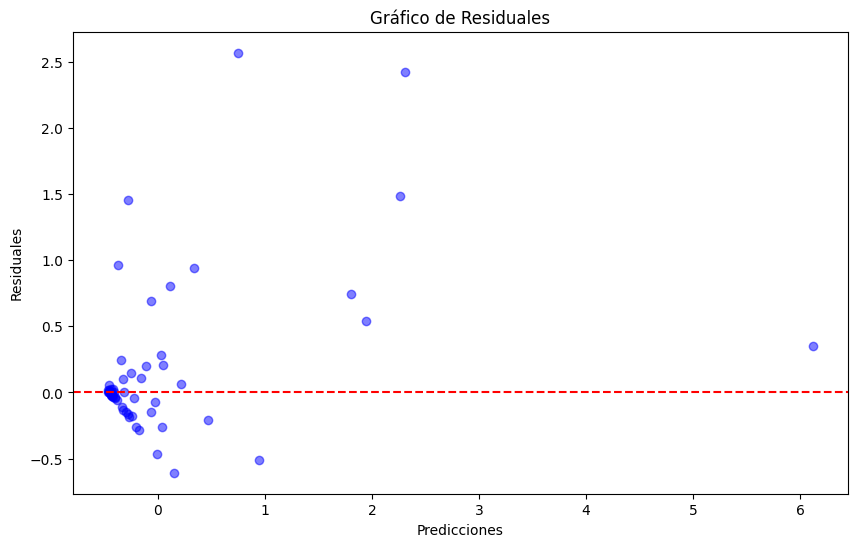

In [54]:
print(y_test.shape)
y_pred_test_new = y_pred_test_new.reshape(-1,1)
print(y_pred_test_new.shape)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_new, y_test - y_pred_test_new, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.show()
